# Group Members
Erik Ström

In [1]:
#%pip install networkx # if you want to run this notebook, you might need to install networkx

# Task 1
## 1)
Since visualizing graphs requires additional packages either way, and is fairly complicated if done from scratch (e.g. using some graphics package), we use the networkx package to facilitate defining our basic graphs as well as visualizing them.  

In [99]:
import networkx as nx
import matplotlib.pyplot as plt
import random 

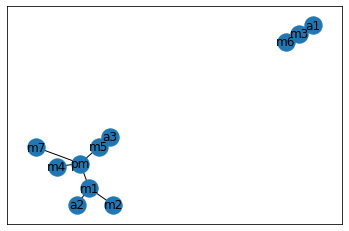

In [253]:
path = "DisCalSn.net"

G = nx.Graph(nx.read_pajek(path, encoding='UTF-8'))

nx.draw_networkx(G)
plt.show()

## 3)
Though there are many ways we could choose to view the communities empirically, there seems to be two reasonable choices. 

In both cases, [a1, m3, m6] should probably be a community, and whether or not we should consider the second component as a community or split it up into different ones is not cleaer. In our case, we consider the community division where [m4, m5, m7, a3, pm], [m1, m2, a2] are separate communities. 

## 4) 
To compute the modularity of this cluster configuration, we write a simple function to calculate it, since it is probably faster than doing the arithmetic.

We essentially only need a way of defining the kronecker delta function as well as our communities and we can use the graph properties to calculate the final modularity.

The community is defined by a string containing all the different nodes in each community

In [263]:
def kronecker_delta_func(node_i, node_j, community_mapping):
    '''
    Param node_i: A node 
    param node_j: A node
    param community_mapping: A list of strings defining the different communities
    
    This function returns 1 if node i and j are in the same community,
    and 0 otherwise
    '''
    for community in community_mapping:
        if node_i in community and node_j in community:
            return True
    return False
    
def graph_modularity(G, community_mapping):
    '''
    param G: A graph
    param community_mapping: A list of strings defining the different communities
    '''
    n_nodes = G.number_of_nodes()
    A = nx.to_numpy_array(G) # returns the adjacency matrix of G as a numpy array
    m = G.number_of_edges() # multiply by 2
    nodes = list(G.nodes()) # so we can send our node labels to kronecker delta func

    modularity = 0
    
    for i in range(n_nodes):
        for j in range(n_nodes):
            modularity += (((A[i][j] > 0) - (G.degree[nodes[i]] * G.degree[nodes[j]]) / (2 * m))) * kronecker_delta_func(nodes[i], nodes[j], community_mapping)
    
    return modularity / (2 * m)

In [265]:
community_mapping = ["a1, m3, m6", "m4, m5, m7, a3, pm", "m1, m2, a2"]
nodes = list(G.nodes())

modularity = graph_modularity(G, community_mapping)

print(f"our modularity calculations: {modularity}")
print(f"built-in modularity calculations: {nx.community.modularity(G, [{'a1', 'm3', 'm6'}, {'m4', 'm5', 'm7', 'a3', 'pm'}, {'m1', 'm2', 'a2'}])}")

our modularity calculations: 0.5123456790123461
built-in modularity calculations: 0.5440625


Comparing to networkx's implementation, the result seems fairly close, this might be due to some small error in the calculations or, or some smaller differences in implementation.

In any case, we get a positive modularity as expected since there seems to be some clear community formation.

# Task 2
For task two, we start by writing methods for generating an erdos-renyl graph, as well as for checking if a graph has an isolated component or not.

In [24]:
def erdos_renyl_rnd_graph(n, p):
    '''
    pram n: number of vertices
    param p: probability that any two nodes 
    are connected by an edge
    This function returns a an erdos-renyl graph G(n, p)
    '''
    G = nx.Graph() # Graph object that is to contain our edges and vertices

    # we start by adding n nodes
    for i in range(n):
        G.add_node(i)

    # iterate over all combinations of 
    # nodes, assuming (i,j) = (j, i), in G
    # and adds an edge with probability p
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p: # random.random() returns a value in [0, 1) randomly
                G.add_edge(i, j)
    return G

def has_isolated_component(G):
    '''
    param G: graph
    Returns true if G has an isolated component,
    otherwise false
    '''
    for node in G.nodes():
        if len(G.edges(node)) == 0:
            return True
    return False

We then generate a large number of graphs and count the fraction of graphs with connected components, where $p$ differs by some small $\epsilon$

In [281]:
n = 15
epsilon = 1e-1
n_simulations = 100000

p_1 = (np.log(n) / n) - epsilon
p_2 = (np.log(n) / n) + epsilon

G_1_has_isolated_component_count = 0
G_2_has_isolated_component_count = 0
# here we simulate a number of random graphs
# and count the fraction of graphs with an isolated component
# for p < ln n / n
for s in range(n_simulations):
    G_1 = erdos_renyl_rnd_graph(n, p_1)
    G_2 = erdos_renyl_rnd_graph(n, p_2)

    G_1_has_isolated_component_count += has_isolated_component(G_1) # bools are treated as 0 (False) 1  (True)
    G_2_has_isolated_component_count += has_isolated_component(G_2) # bools are treated as 0 (False) 1  (True)

print(f"p < ln(n) / n \n% of G with isolated comp: {G_1_has_isolated_component_count / n_simulations}")
print(f"p > ln(n) / n\n% of G with isolated comp: {G_2_has_isolated_component_count / n_simulations}")

p < ln(n) / n 
% of G with isolated comp: 0.98789
p > ln(n) / n
% of G with isolated comp: 0.13502


Indeed it seems as though for small changes around $p = \frac{\ln n}{n}$ the connected- or disconectedness of the graph changes drastically. It seems as though the percent of graphs with isolated components might somehow be changing symmetrically around $p$ as we change $\epsilon$? We investigate if this is the case for more epsilons.

In [282]:
n_simulations = 100000
n = 15
n_epsilons = 20

results = []
epsilon_linspace = np.linspace(1e-1, 1e-5, num=n_epsilons)

for epsilon in epsilon_linspace:
    p_1 = (np.log(n) / n) - epsilon
    p_2 = (np.log(n) / n) + epsilon
    
    G_1_has_isolated_component_count = 0
    G_2_has_isolated_component_count = 0
    # here we simulate a number of random graphs
    # and count the fraction of graphs with an isolated component
    # for p < ln n / n
    for s in range(n_simulations):
        G_1 = erdos_renyl_rnd_graph(n, p_1)
        G_2 = erdos_renyl_rnd_graph(n, p_2)
        
        G_1_has_isolated_component_count += has_isolated_component(G_1) # bools are treated as 0 (False) 1  (True)
        G_2_has_isolated_component_count += has_isolated_component(G_2) # bools are treated as 0 (False) 1  (True)
    results.append((G_1_has_isolated_component_count + G_2_has_isolated_component_count) / n_simulations)

No handles with labels found to put in legend.


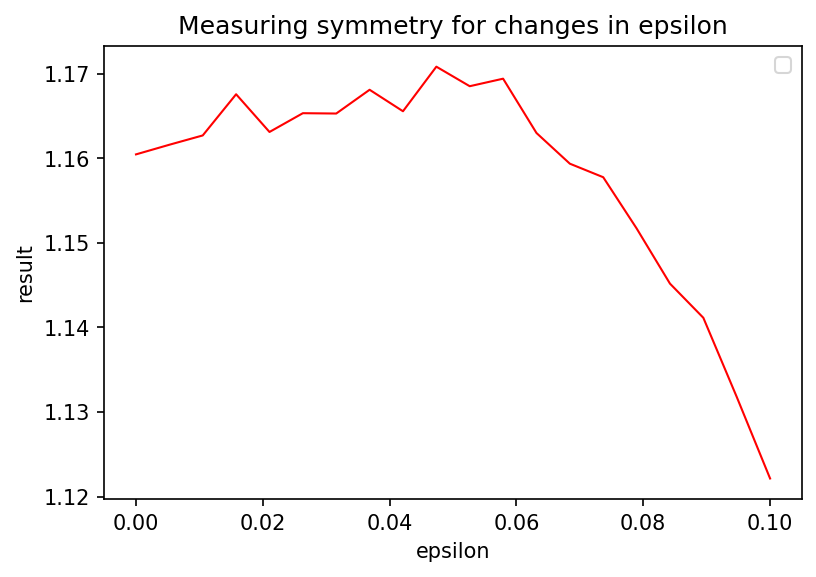

In [287]:
plt.figure(dpi=150)

plt.plot(epsilon_linspace, results, 'r-', linewidth=1)
plt.legend()
plt.title("Measuring symmetry for changes in epsilon")
plt.xlabel("epsilon")
plt.ylabel("result")
plt.show()

Seems to not be the case.

# Task 3
To calculate the global clustering coefficient of a graph, we use the formula given by wolfram. 

To understand the formulation, the important part is to understand that the power of the adjacency matrix represents the number of walks between the entries in the matrix. For example, the number of triangles in a graph is calculated as the trace of $\mathbf{A}^3$ since any 3-walk that starts and ends in node $i$ forms a triangle. The number of 2-paths is calculated in a similar way, taking special care to distinguish between walks and paths.


In [96]:
def cluster_coeff(G):
    '''
    param G: a graph 
    This function returns the global cluster coefficient
    of a graph G calculated using its adjacency matrix  
    '''
    A = nx.to_numpy_array(G) # returns the adjacency matrix of G as a numpy array
    
    # we first calculate A^2 and store it in an array for efficiency
    # and then calculate A^3 by using our stored A^2 and multiplying by A
    A_squared = np.linalg.matrix_power(A, 2)
    n_2_paths = np.sum(A_squared) - np.trace(A_squared) # sum all non-diagonal elements of A^2 
    if n_2_paths == 0: # ensure we dont divide by 0
        return 0
    n_triangles = np.trace(A_squared @ A) # trace of A^3 (sum of diag elements)
    return n_triangles / n_2_paths

we then generate some graphs and estimate the expected clustering coefficients for some proabilities

In [111]:
n = 100
n_simulations = 100

n_p_points = 100
p_linspace = np.linspace(start=0, stop=1, num=n_p_points)
y = np.zeros(n_p_points)
for i, p in enumerate(p_linspace):
    avg_cluster_coeff = 0
    for _ in range(n_simulations):
        G = erdos_renyl_rnd_graph(n, p)
        avg_cluster_coeff += cluster_coeff(G)
    y[i] = avg_cluster_coeff / n_simulations

and plot the results

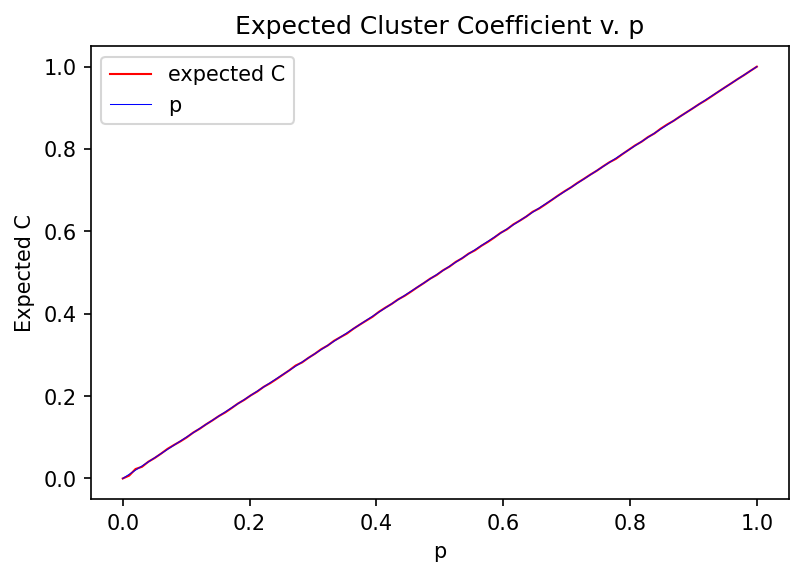

In [119]:
plt.figure(dpi=150)

plt.plot(p_linspace, y, 'r-', label='expected C', linewidth=1)
plt.plot(p_linspace, p_linspace, 'b-', label='p', linewidth=0.5)

plt.legend()
plt.title("Expected Cluster Coefficient v. p")
plt.xlabel("p")
plt.ylabel("Expected C")
plt.show()

Indeed, the cluster coefficient seems to roughly follow $p$